In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import PIL
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import os

import matplotlib.pyplot as plt

import pathlib
# for reproducibility (does not guarantee fully reproducible results )
import random
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2024-06-09 16:53:28.243122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 16:53:28.243183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 16:53:28.244586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import imghdr

# Define the input and output directories
input_dir = '/kaggle/input/skindataset'
output_dir = '/kaggle/working/skindataset-copy'

# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Valid image types
valid_image_types = {'jpeg', 'png', 'gif', 'bmp'}

# Walk through the input directory tree
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            # Construct the full file path
            file_path = os.path.join(root, file)
            # Verify the image type
            image_type = imghdr.what(file_path)
            if image_type in valid_image_types:
                # Construct the corresponding output directory path
                rel_path = os.path.relpath(root, input_dir)
                dest_dir = os.path.join(output_dir, rel_path)
                # Create the directory if it does not exist
                os.makedirs(dest_dir, exist_ok=True)
                # Copy the file to the output directory
                shutil.copy(file_path, dest_dir)

print("Files copied successfully.")


Files copied successfully.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/kaggle/working/skindataset-copy/6 classes/train'
test_dir = '/kaggle/working/skindataset-copy/6 classes/test'

IMG_SIZE = 128
seed = 123
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,subset = "training",
    seed = 123,
    batch_size=BATCH_SIZE,
    image_size= (IMG_SIZE, IMG_SIZE),
#     label_mode = 'categorical'
)

val_ds  = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,subset = "validation",
    seed = 123,
    batch_size=BATCH_SIZE,
    image_size= (IMG_SIZE, IMG_SIZE),
#     label_mode = 'categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  batch_size=1,
  shuffle=False,
  image_size= (IMG_SIZE, IMG_SIZE),
#     label_mode = 'categorical'
)

Found 7440 files belonging to 6 classes.
Using 5952 files for training.
Found 7440 files belonging to 6 classes.
Using 1488 files for validation.
Found 1643 files belonging to 6 classes.


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 128, 128, 3)
(64,)


# Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1, ),
        layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1),),
      #  layers.RandomContrast(factor=0.2),
      #  layers.RandomBrightness(factor=0.0001),
        layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
    ])

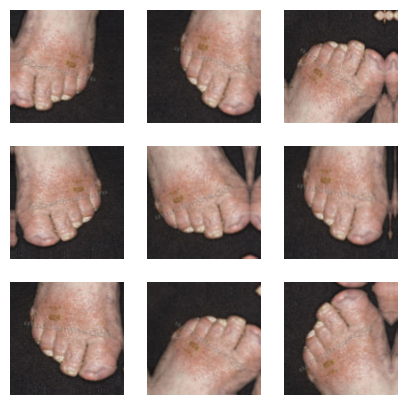

In [9]:
tf.get_logger().setLevel('ERROR')
image, label = next(iter(train_ds))
image = image[0]/255
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(5, 5))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds,shuffle = False,augment = True):
    if shuffle:
        ds = ds.shuffle(seed)
    if augment:
        ds = ds.map(lambda x,y:(data_augmentation(x,training = True),y),num_parallel_calls = AUTOTUNE)

    return ds.prefetch(buffer_size = AUTOTUNE)

In [11]:
train_data = prepare(train_ds, shuffle=True,augment = True)
val_data = prepare(val_ds,augment=False)
test_data = prepare(test_ds,augment=False)

## Modeling

### EfficientNetV2

In [3]:
efficientnet2 = Sequential([
    tf.keras.applications.EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    layers.Flatten(),
     layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(6)
])
efficientnet2.layers[0].trainable = False

In [21]:
efficientnet2.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# mlp = CastingQuality(num_classes=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

checkpoint_filepath = 'tmp/efficientnet.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs=100
history = efficientnet2.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback,model_checkpoint_callback]
)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - accuracy: 0.4664 - loss: 1.3372 - val_accuracy: 0.6069 - val_loss: 0.9608
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.6193 - loss: 0.9242 - val_accuracy: 0.6405 - val_loss: 0.8740
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.6507 - loss: 0.8417 - val_accuracy: 0.6478 - val_loss: 0.8572
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.6770 - loss: 0.7768 - val_accuracy: 0.6667 - val_loss: 0.8653
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.6987 - loss: 0.7421 - val_accuracy: 0.6707 - val_loss: 0.8092
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.7128 - loss: 0.7127 - val_accuracy: 0.6707 - val_loss: 0.8565
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.7262 - loss: 0.6694 - val_accuracy: 0.6862 - val_loss: 0.7985
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.7234 - loss: 0.6724 - 

## EfficientNet

In [22]:
efficientnet = Sequential([
    tf.keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    layers.Flatten(),
     layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(6)
])
efficientnet.layers[0].trainable = False

efficientnet.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# mlp = CastingQuality(num_classes=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

checkpoint_filepath = 'tmp/efficientnetv1.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs=100
historyv1 = efficientnet.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback,model_checkpoint_callback]
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.4374 - loss: 1.4374 - val_accuracy: 0.5605 - val_loss: 1.0028
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.5707 - loss: 1.0183 - val_accuracy: 0.5914 - val_loss: 0.9787
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.6017 - loss: 0.9289 - val_accuracy: 0.5968 - val_loss: 1.0028
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.6410 - loss: 0.8770 - val_accuracy: 0.6042 - val_loss: 0.9467
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.6391 - loss: 0.8674 - val_accuracy: 0.6270 - val_loss: 0.8887
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.6637 - loss: 0.8159 - val_accuracy: 0.6492 - val_loss: 0.8621
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.6596 - loss: 0.8179 - val_accuracy: 0.6741 - val_loss: 0.8019
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 

## DenseNet

In [16]:
densenet121 = Sequential([
    layers.Lambda(tf.keras.applications.densenet.preprocess_input,input_shape=(128, 128, 3)),
    tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    layers.Flatten(),
     layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(6)
])
densenet121.layers[0].trainable = False

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
densenet121.load_weights('/kaggle/working/tmp/densenet121.weights.h5')

In [19]:
densenet121.export('densenet121')

Saved artifact at 'densenet121'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_4043')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135658182761408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182757536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182767392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182765984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182764224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182804928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182807744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182805456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182806160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135658182811264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13565818281073

In [31]:
densenet121 = Sequential([
    layers.Lambda(tf.keras.applications.densenet.preprocess_input,input_shape=(128, 128, 3)),
    tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    layers.Flatten(),
     layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(6)
])
densenet121.layers[0].trainable = False

densenet121.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# mlp = CastingQuality(num_classes=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True)

checkpoint_filepath = 'tmp/densenet121.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs=100
historydense = densenet121.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback,model_checkpoint_callback]
)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 154s 323ms/step - accuracy: 0.3182 - loss: 6.5755 - val_accuracy: 0.4052 - val_loss: 1.9372
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.4878 - loss: 1.1315 - val_accuracy: 0.4778 - val_loss: 1.4019
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.5793 - loss: 0.9612 - val_accuracy: 0.5276 - val_loss: 1.2368
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - accuracy: 0.6066 - loss: 0.9260 - val_accuracy: 0.5880 - val_loss: 1.0463
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.6407 - loss: 0.8787 - val_accuracy: 0.5202 - val_loss: 1.3103
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.6662 - loss: 0.7948 - val_accuracy: 0.5121 - val_loss: 1.2212
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.6651 - loss: 0.7765 - val_accuracy: 0.5672 - val_loss: 1.4923
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.7040 - loss: 0.7155 -

In [37]:
import pandas as pd
df_effnetv2 = pd.DataFrame(history.history)
df_effnetv1 = pd.DataFrame(historyv1.history)
df_densenet = pd.DataFrame(historydense.history)

df_effnetv2.to_csv("effnetv2.csv")
df_effnetv1.to_csv("effnetv1.csv")
df_densenet.to_csv("densenet.csv")

# Evaluasi Model

In [48]:
test_ds.class_names

['Acne and Rosacea Photos',
 'Eczema Photos',
 'Normal',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'vitiligo']

## EfficientNetV2

In [9]:
from sklearn.metrics import classification_report
# efficientnet2.load_weights("/kaggle/working/tmp/efficientnet.weights.h5")
efficientnet2 = keras.models.load_model("/kaggle/working/efficientnetV2.h5")
y_pred_test = efficientnet2.predict(test_ds)
y_true_test = np.concatenate([y for x, y in test_ds], axis=0)

print('test report')
print(classification_report(y_true_test, y_pred_test.argmax(axis = 1), digits=5))

  14/1643 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step  

I0000 00:00:1717951832.100299    6014 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step
test report
              precision    recall  f1-score   support

           0    0.75287   0.83974   0.79394       312
           1    0.61246   0.57282   0.59197       309
           2    0.97207   0.90155   0.93548       193
           3    0.60586   0.52841   0.56449       352
           4    0.55000   0.64308   0.59291       325
           5    0.95000   0.87500   0.91096       152

    accuracy                        0.69446      1643
   macro avg    0.74054   0.72677   0.73163      1643
weighted avg    0.69882   0.69446   0.69449      1643



## EfficientNetV1

In [49]:
from sklearn.metrics import classification_report
efficientnet.load_weights("/kaggle/working/tmp/efficientnetv1.weights.h5")
y_pred_test = efficientnet.predict(test_ds)
y_true_test = np.concatenate([y for x, y in test_ds], axis=0)

print('test report')
print(classification_report(y_true_test, y_pred_test.argmax(axis = 1), digits=5))

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step
test report
              precision    recall  f1-score   support

           0    0.66049   0.68590   0.67296       312
           1    0.54167   0.46278   0.49913       309
           2    0.92571   0.83938   0.88043       193
           3    0.44516   0.58807   0.50673       352
           4    0.52667   0.48615   0.50560       325
           5    0.96522   0.73026   0.83146       152

    accuracy                        0.60560      1643
   macro avg    0.67749   0.63209   0.64939      1643
weighted avg    0.62489   0.60560   0.61058      1643



## DenseNet

In [50]:
from sklearn.metrics import classification_report
densenet121.load_weights("/kaggle/working/tmp/densenet121.weights.h5")
y_pred_test = densenet121.predict(test_ds)
y_true_test = np.concatenate([y for x, y in test_ds], axis=0)

print('test report')
print(classification_report(y_true_test, y_pred_test.argmax(axis = 1), digits=5))

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step
test report
              precision    recall  f1-score   support

           0    0.79618   0.80128   0.79872       312
           1    0.75500   0.48867   0.59332       309
           2    0.96392   0.96891   0.96641       193
           3    0.54066   0.69886   0.60967       352
           4    0.67568   0.69231   0.68389       325
           5    0.97959   0.94737   0.96321       152

    accuracy                        0.73220      1643
   macro avg    0.78517   0.76623   0.76920      1643
weighted avg    0.74653   0.73220   0.73179      1643



# Saving Model

In [52]:
efficientnet2.save('efficientnetV2.h5')
efficientnet.save('efficientnetV1.h5')
densenet121.save('densenet121.h5')

In [ ]:
densenet = keras.models.load_model("/kaggle/working/densenet121.h5")
densenet.export('dense121')

In [22]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("densenet121")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('model_quantized_densenet121.tflite', 'wb') as f:
    f.write(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 195, Total Ops 634, % non-converted = 30.76 %
 * 195 ARITH ops

- arith.constant:  195 occurrences  (f32: 192, i32: 3)



  (f32: 63)
  (f32: 3)
  (f32: 58)
  (f32: 120)
  (f32: 2)
  (f32: 1)
  (f32: 64)
  (f32: 2)
  (uq_8: 122)
  (f32: 1)


# Using TFLITE for prediction

In [37]:
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the image size (same as during training)
IMG_SIZE = 128
class_names = ['Acne and Rosacea Photos','Eczema Photos',
               'Normal','Psoriasis pictures Lichen Planus and related diseases', 
               'Tinea Ringworm Candidiasis and other Fungal Infections', 'vitiligo']

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to your test image
image_path = '/kaggle/input/skindataset/6 classes/train/Acne and Rosacea Photos/07Acne081101.jpg'
input_data = preprocess_image(image_path)


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/kaggle/working/model_quantized_densenet121.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
prediction = class_names[output_data.argmax(axis = 1)[0]]
print(prediction)

Acne and Rosacea Photos
